In [1]:
# Importing packages

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.interpolate import UnivariateSpline
from scipy import integrate

In [2]:
# Defining function with sine wave noise of defined frequency, along with other parameters for FFT

Fs = 300.0; # sampling rate
Ts = 1.0/Fs; # sampling interval
t = np.arange(-1,1,Ts) # time vector
y = t**2 # example function whose extrema are to be found
ff = 10; # frequency of the noise signal
noise = 0.1*np.sin(2*np.pi*ff*t) # example sine wave noise signal

y += noise # example function with noise whose extrema are to be found

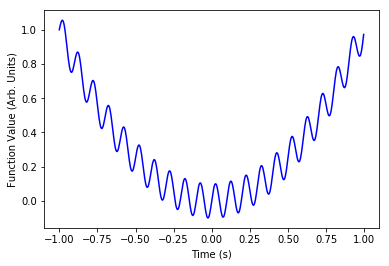

In [3]:
# Plotting function with noise

plt.plot(t,y,'b')
plt.xlabel('Time (s)')
plt.ylabel('Function Value (Arb. Units)')

plt.show()

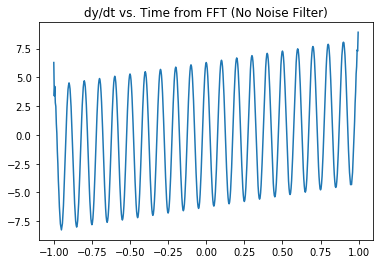

In [4]:
# FFT differentiation

frq = np.fft.fftfreq(t.shape[-1])*Fs # frequency spectra, in standard order (zero, positive, then negative frequencies)

Yk = np.fft.fft(y) # compute Fourier coefficients Yk of function with noise, return array with Fourier coefficients Yk in standard order

Ykprime = [0]*len(Yk) # initialize Ykprime array
Ykprime = (2.0*np.pi*1j)*frq*Yk # compute Fourier coefficients of derivative of function with noise Yk', return array with Fourier coefficients Yk' in standard order
        
yprime = np.real(np.fft.ifft(Ykprime)) # inverse FFT of Ykprime gives derivative of original function with noise in time domain

plt.plot(t,yprime)
plt.title('dy/dt vs. Time from FFT (No Noise Filter)')
plt.show()

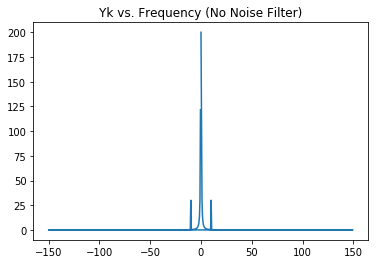

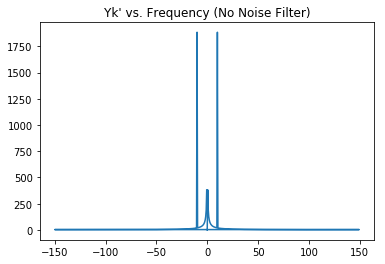

In [5]:
# Plot of Fourier coefficients versus frequency

plt.plot(frq,np.absolute(Yk))
# plt.xlim(-ff-10, ff+10)
plt.title('Yk vs. Frequency (No Noise Filter)')
plt.show()
plt.plot(frq,np.absolute(Ykprime))
# plt.xlim(-ff-10, ff+10)
plt.title("Yk' vs. Frequency (No Noise Filter)")
plt.show()

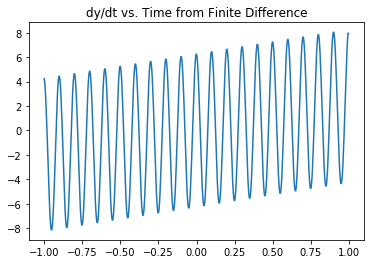

In [6]:
# Finite difference function differentiation, for comparison with FFT differentiation
# Computes derivative by taking difference of adjacent array elements of function, divided by the uniform time spacing

directyprime = [0]*len(y)

directyprime[0:-1] = np.diff(y)/np.diff(t)
directyprime[-1] = (y[-1] - y[-2])/(t[-1] - t[-2])

plt.plot(t,directyprime)
plt.title('dy/dt vs. Time from Finite Difference')
plt.show()

In [7]:
# Detect frequencies arising from noise

noise_threshold = 10**(-7) # detection threshold of Fourier coefficients arising from noise

detectednoisefrq = [] # instantiate list which will include all frequencies detected to be from noise

# Note: Ykprime equals zero for extrema, so this detection method should not detect extrema as noise
for i in range(0,len(Ykprime)):
    if np.real(Ykprime[i]) >= noise_threshold: # detecting noise if real part of Fourier coefficients Yk' above a threshold
        detectednoisefrq.append(frq[i])

print(detectednoisefrq)

[10.0, -10.0]


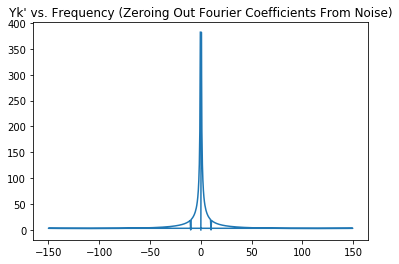

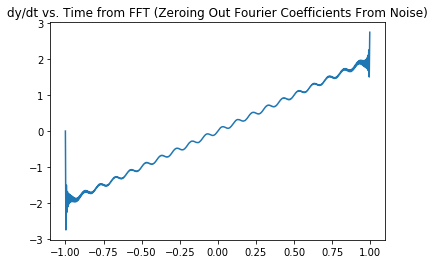

In [8]:
# Filter out sine wave noise by zeroing Fourier coefficients corresponding to noise

filteredykprime = [0]*len(Ykprime) # initialize as zero array
filteredykprime = Ykprime[:] # initial values of filteredykprime are unfiltered values of Ykprime; Ykprime[:] makes sure manipulations to filteredykprime don't affect Ykprime

for i in range(0,len(Ykprime)):
    if frq[i] in detectednoisefrq:
        filteredykprime[i] = 0       
        
plt.plot(frq,np.absolute(Ykprime))
# plt.xlim(-ff-10, ff+10)
plt.title("Yk' vs. Frequency (Zeroing Out Fourier Coefficients From Noise)")
plt.show()

yprime = np.real(np.fft.ifft(filteredykprime)) # inverse FFT of Ykprime gives derivative of original function with noise in time domain

plt.plot(t,yprime)
plt.title('dy/dt vs. Time from FFT (Zeroing Out Fourier Coefficients From Noise)')
plt.show()

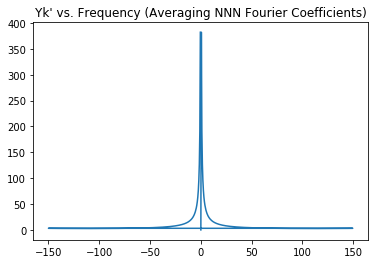

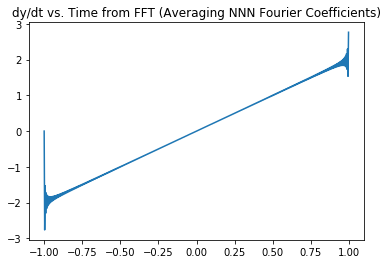

In [9]:
# Filter out sine wave noise by averaging next nearest neighbor values of Yk' near detected noise frequencies

filteredykprime = [0]*len(Ykprime) # initialize as zero array
filteredykprime = Ykprime[:] # initial values of filteredykprime are unfiltered values of Ykprime; Ykprime[:] makes sure manipulations to filteredykprime don't affect Ykprime

# Based on detected noise frequencies, filter by replacing Ykprime value at that frequency with average value of next nearest neighbors
for i in range(0,len(Ykprime)):
    if frq[i] in detectednoisefrq:
        filteredykprime[i] = (filteredykprime[i-1]+filteredykprime[i+1])*(1.0/2) # filteredykprime contains complex numbers, so np.average() and np.mean don't work       
        
plt.plot(frq,np.absolute(filteredykprime))
plt.title("Yk' vs. Frequency (Averaging NNN Fourier Coefficients)")
plt.show()

filteredyprime = np.real(np.fft.ifft(filteredykprime)) # inverse FFT of Ykprime gives derivative of original function

plt.plot(t,filteredyprime)
plt.title('dy/dt vs. Time from FFT (Averaging NNN Fourier Coefficients)')
plt.show()

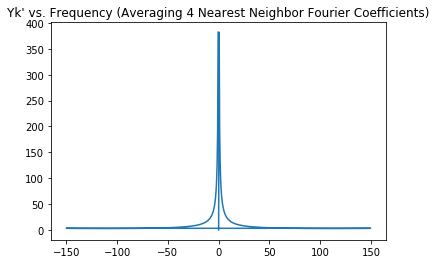

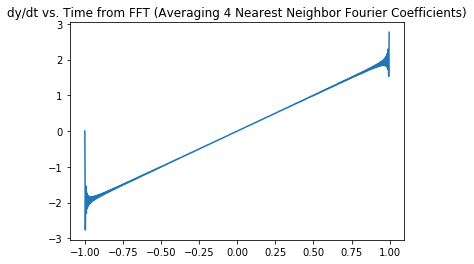

In [10]:
# Filter out sine wave noise by averaging N nearest neighbor values of Yk' near detected noise frequencies

nearest_neighbors = 4
filteredykprime = [0]*len(Ykprime)
filteredykprime = Ykprime[:]

for i in range(0,len(Ykprime)):
    if frq[i] in detectednoisefrq:
        filteredykprime[i] = 0
        for k in range(1,nearest_neighbors+1):
            filteredykprime[i] += (Ykprime[i-k]+Ykprime[i+k])*(0.5/nearest_neighbors)
            
plt.plot(frq,np.absolute(filteredykprime))
plt.title("Yk' vs. Frequency (Averaging %d Nearest Neighbor Fourier Coefficients)" % nearest_neighbors)
# plt.xlim(-ff-5, ff+5)
plt.show()

filteredyprime = np.real(np.fft.ifft(filteredykprime)) # inverse FFT of Ykprime gives derivative of original function

plt.plot(t,filteredyprime)
plt.title('dy/dt vs. Time from FFT (Averaging %d Nearest Neighbor Fourier Coefficients)' % nearest_neighbors)
plt.show()

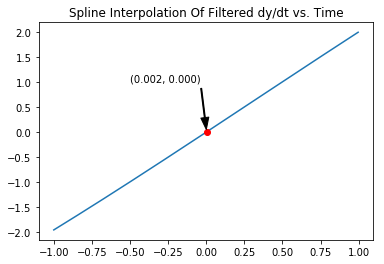

In [11]:
# Find zeros of filtered dy/dt to find extrema

spl = UnivariateSpline(t,filteredyprime)
interpolatedroots = spl.roots()

plt.plot(t, spl(t))
plt.plot(interpolatedroots, spl(interpolatedroots), 'or')
plt.annotate('(%0.3f, %0.3f)' % (interpolatedroots, spl(interpolatedroots)), xy=(interpolatedroots, spl(interpolatedroots)), xytext=(-0.5, 1),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))
plt.title("Spline Interpolation Of Filtered dy/dt vs. Time")
plt.show()

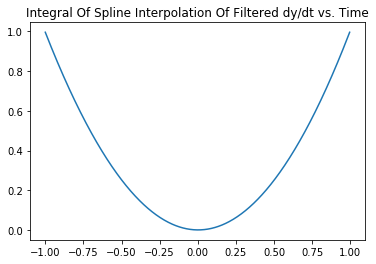

In [12]:
# Integrate spline interpolation of filtered dy/dt to get filtered y

filtered_y = [0]*len(t)

for i,val in enumerate(t):
    inty,err = integrate.quad(spl, 0, val)
    filtered_y[i] = inty
    
plt.plot(t, filtered_y)
plt.title("Integral Of Spline Interpolation Of Filtered dy/dt vs. Time")
plt.show()

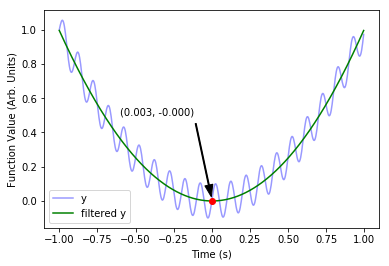

In [13]:
# Plotting function with noise, labeling estimated extremal point

estimated_t_extrema = t[np.abs(t-interpolatedroots).argmin()]
estimated_y_extrema = filtered_y[np.abs(t-interpolatedroots).argmin()]


# Code that could be useful for multiple extremal points
# estimated_t_extrema = [0]*len(interpolatedroots)
# estimated_y_extrema = [0]*len(interpolatedroots)

# for i in range(0,len(interpolatedroots)):
#    estimated_t_extrema[i] = t[np.abs(t-interpolatedroots[i]).argmin()]
#    estimated_y_extrema[i] = filtered_y[np.abs(t-interpolatedroots[i]).argmin()]


plt.plot(t,y,'b',alpha=0.4,label = "y")
plt.plot(t,filtered_y,'g',label = "filtered y")
plt.plot(estimated_t_extrema, estimated_y_extrema, 'or')
plt.annotate('(%0.3f, %0.3f)' % (estimated_t_extrema,estimated_y_extrema), xy=(estimated_t_extrema,estimated_y_extrema), xytext=(-0.6, 0.5),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))
plt.xlabel('Time (s)')
plt.ylabel('Function Value (Arb. Units)')

plt.legend()
plt.show()